In [ ]:
import pandas as pd
from google.cloud import bigquery
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col, isnan

client = bigquery.Client.from_service_account_json('YOUR_JSON.json')
spark = SparkSession.builder.appName("COVID Vaccination Intent Prediction").getOrCreate()

query = """
SELECT
    EXTRACT(YEAR FROM date) AS year,
    EXTRACT(WEEK FROM date) AS week,
    AVG(sni_vaccination_intent) * 100 AS avg_vaccination_intent,
    AVG(sni_covid19_vaccination) * 100 AS avg_vaccination_rate,
    AVG(sni_safety_side_effects) * 100 AS avg_side_effect_interest
FROM
    `bigquery-public-data.covid19_vaccination_search_insights.covid19_vaccination_search_insights`
GROUP BY
    year, week
ORDER BY
    year, week;
"""

df = client.query(query).to_dataframe()
spark_df = spark.createDataFrame(df)

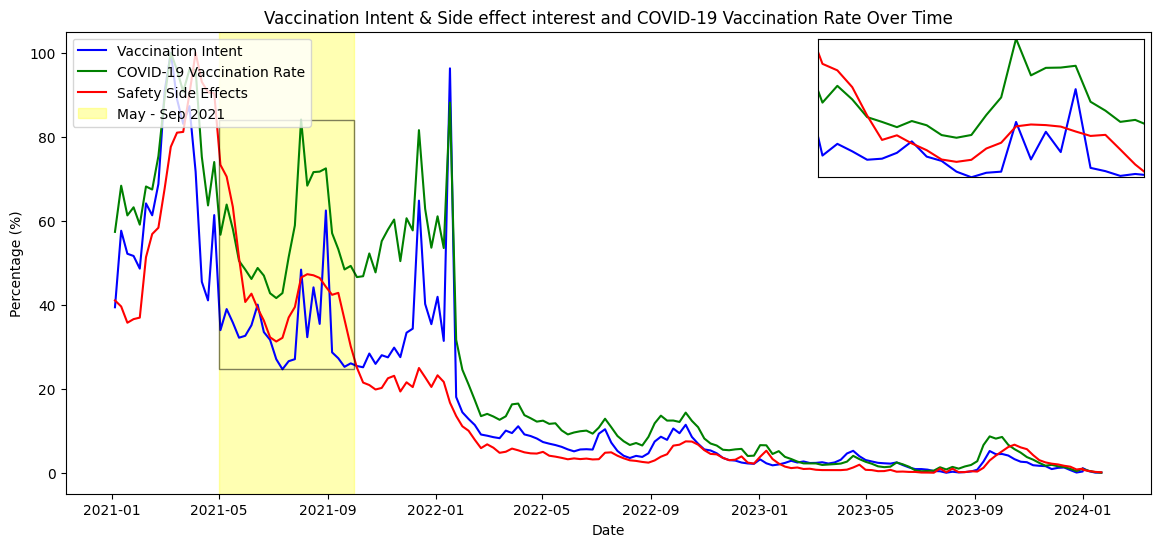

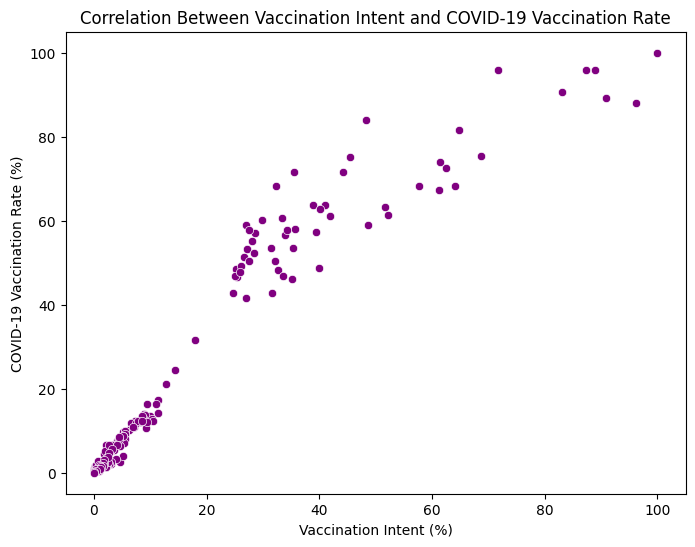

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week'].astype(str) + '-1', format='%Y-%W-%w')
df['avg_vaccination_intent'] = 100 * (df['avg_vaccination_intent'] - df['avg_vaccination_intent'].min()) / (df['avg_vaccination_intent'].max() - df['avg_vaccination_intent'].min())
df['avg_vaccination_rate'] = 100 * (df['avg_vaccination_rate'] - df['avg_vaccination_rate'].min()) / (df['avg_vaccination_rate'].max() - df['avg_vaccination_rate'].min())
df['avg_side_effect_interest'] = 100 * (df['avg_side_effect_interest'] - df['avg_side_effect_interest'].min()) / (df['avg_side_effect_interest'].max() - df['avg_side_effect_interest'].min())

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['date'], df['avg_vaccination_intent'], color='blue', label='Vaccination Intent')
ax.plot(df['date'], df['avg_vaccination_rate'], color='green', label='COVID-19 Vaccination Rate')
ax.plot(df['date'], df['avg_side_effect_interest'], color='red', label='Safety Side Effects')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage (%)')
ax.set_title('Vaccination Intent & Side effect interest and COVID-19 Vaccination Rate Over Time')

ax.axvspan(pd.to_datetime("2021-05-01"), pd.to_datetime("2021-10-01"), color="yellow", alpha=0.3, label="May - Sep 2021")

axins = inset_axes(ax, width="30%", height="30%", loc="upper right")
axins.plot(df['date'], df['avg_vaccination_intent'], color='blue')
axins.plot(df['date'], df['avg_vaccination_rate'], color='green')
axins.plot(df['date'], df['avg_side_effect_interest'], color='red')

axins.set_xlim(pd.to_datetime("2021-05-01"), pd.to_datetime("2021-10-01"))
axins.set_ylim(
    df[(df['date'] >= "2021-05-01") & (df['date'] <= "2021-10-01")][['avg_vaccination_intent', 'avg_vaccination_rate','avg_side_effect_interest']].min().min(),
    df[(df['date'] >= "2021-05-01") & (df['date'] <= "2021-10-01")][['avg_vaccination_intent', 'avg_vaccination_rate','avg_side_effect_interest']].max().max()
)

axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.legend(loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='avg_vaccination_intent', y='avg_vaccination_rate', color='purple')
plt.xlabel('Vaccination Intent (%)')
plt.ylabel('COVID-19 Vaccination Rate (%)')
plt.title('Correlation Between Vaccination Intent and COVID-19 Vaccination Rate')
plt.show()


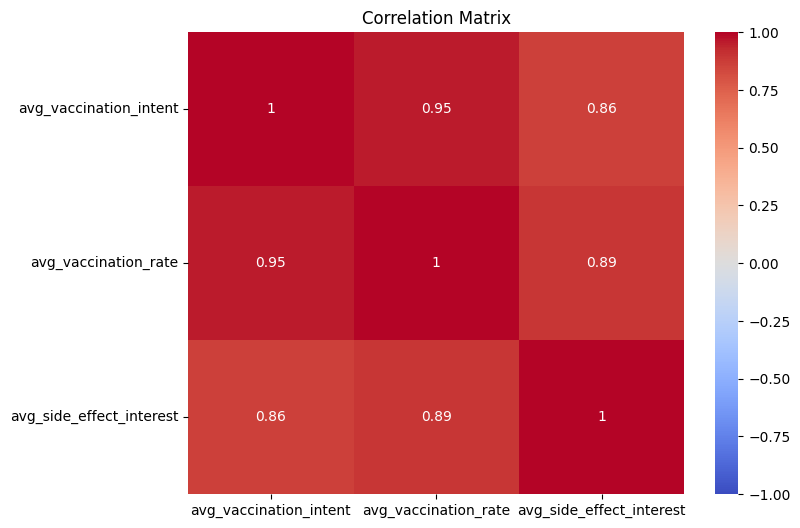

In [ ]:
correlation_matrix = df[["avg_vaccination_intent", "avg_vaccination_rate", "avg_side_effect_interest"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
spark_df.show(5)

+----+----+----------------------+--------------------+------------------------+
|year|week|avg_vaccination_intent|avg_vaccination_rate|avg_side_effect_interest|
+----+----+----------------------+--------------------+------------------------+
|2021|   1|    1587.9516808830895|    4980.22315907813|       822.3714943886589|
|2021|   2|    2280.2613858182804|   5888.147059122826|        795.138433908046|
|2021|   3|    2071.8179004258127|   5304.018980126333|       722.1888110599083|
|2021|   4|      2051.88342646341|   5463.681813527213|       738.3830164455582|
|2021|   5|    1937.2831456395186|   5122.297847478477|       745.1128671071949|
+----+----+----------------------+--------------------+------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

assembler = VectorAssembler(
    inputCols=["year", "week", "avg_vaccination_intent", "avg_side_effect_interest"],
    outputCol="features"
)
data = assembler.transform(spark_df)

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

scalerModel = scaler.fit(data)

scaledData = scalerModel.transform(data)

train_data = scaledData.limit(scaledData.count() - 52)

test_data = scaledData.orderBy("year", "week").limit(52)

train_df = train_data.select(col("scaledFeatures").alias("features"), col("avg_vaccination_rate").alias("label"))
test_df = test_data.select(col("scaledFeatures").alias("features"), col("avg_vaccination_rate").alias("label"))

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")

lr_r2 = evaluator_r2.evaluate(lr_predictions)
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_mse = evaluator_mse.evaluate(lr_predictions)

dt_r2 = evaluator_r2.evaluate(dt_predictions)
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_mse = evaluator_mse.evaluate(dt_predictions)

print("Linear Regression Metrics:")
print(f"R2: {lr_r2}")
print(f"RMSE: {lr_rmse}")
print(f"MSE: {lr_mse}")
print()
print("Decision Tree Regression Metrics:")
print(f"R2: {dt_r2}")
print(f"RMSE: {dt_rmse}")
print(f"MSE: {dt_mse}")


Linear Regression Metrics:
R2: 0.7651996471072143
RMSE: 610.2331692958167
MSE: 372384.5209088168

Decision Tree Regression Metrics:
R2: 0.9515052203205049
RMSE: 277.32813604745894
MSE: 76910.8950435579


In [ ]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

rf_r2 = evaluator_r2.evaluate(rf_predictions)
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mse = evaluator_mse.evaluate(rf_predictions)

gbt_r2 = evaluator_r2.evaluate(gbt_predictions)
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_mse = evaluator_mse.evaluate(gbt_predictions)

print("Random Forest Regression Metrics:")
print(f"R2: {rf_r2}")
print(f"RMSE: {rf_rmse}")
print(f"MSE: {rf_mse}\n")

print("Gradient-Boosted Tree Regression Metrics:")
print(f"R2: {gbt_r2}")
print(f"RMSE: {gbt_rmse}")
print(f"MSE: {gbt_mse}\n")

Random Forest Regression Metrics:
R2: 0.9418191541752065
RMSE: 303.7641047418175
MSE: 92272.63132959789

Gradient-Boosted Tree Regression Metrics:
R2: 0.9946842724957469
RMSE: 91.81799234096721
MSE: 8430.543717525914



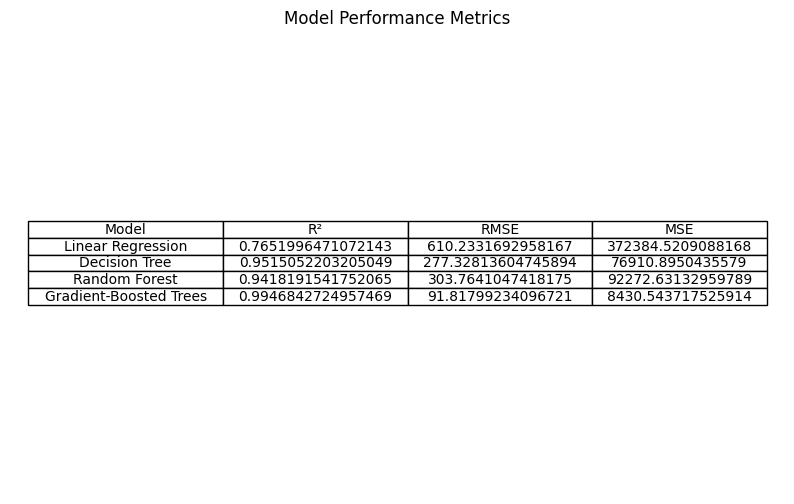

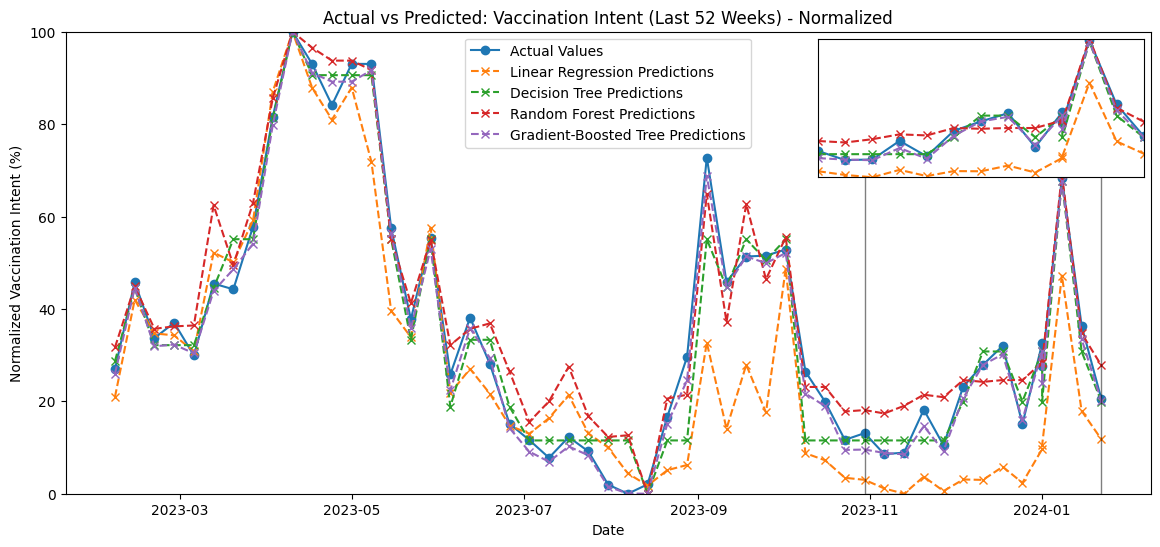

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.pyplot as plt
import numpy as np
actual_values = np.array(test_data.select("avg_vaccination_rate").collect())
actual_values = actual_values.flatten()
lr_predicted_values = np.array([row.prediction for row in lr_predictions.collect()])
dt_predicted_values = np.array([row.prediction for row in dt_predictions.collect()])
rf_predicted_values = np.array([row.prediction for row in rf_predictions.collect()])
gbt_predicted_values = np.array([row.prediction for row in gbt_predictions.collect()])

actual_dates = np.array(df['date'][-52:])
actual_values_normalized = 100 * (actual_values - actual_values.min()) / (actual_values.max() - actual_values.min())
lr_predicted_values_normalized = 100 * (lr_predicted_values - lr_predicted_values.min()) / (lr_predicted_values.max() - lr_predicted_values.min())
dt_predicted_values_normalized = 100 * (dt_predicted_values - dt_predicted_values.min()) / (dt_predicted_values.max() - dt_predicted_values.min())
rf_predicted_values_normalized = 100 * (rf_predicted_values - rf_predicted_values.min()) / (rf_predicted_values.max() - rf_predicted_values.min())
gbt_predicted_values_normalized = 100 * (gbt_predicted_values - gbt_predicted_values.min()) / (gbt_predicted_values.max() - gbt_predicted_values.min())

metrics_data = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "Gradient-Boosted Trees"],
    "R²": [lr_r2, dt_r2, rf_r2, gbt_r2],
    "RMSE": [lr_rmse, dt_rmse, rf_rmse, gbt_rmse],
    "MSE": [lr_mse, dt_mse, rf_mse, gbt_mse]
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(metrics_df.columns))))

plt.title("Model Performance Metrics")
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
ax.plot(actual_dates, lr_predicted_values_normalized, label="Linear Regression Predictions", linestyle='--', marker='x')
ax.plot(actual_dates, dt_predicted_values_normalized, label="Decision Tree Predictions", linestyle='--', marker='x')
ax.plot(actual_dates, rf_predicted_values_normalized, label="Random Forest Predictions", linestyle='--', marker='x')
ax.plot(actual_dates, gbt_predicted_values_normalized, label="Gradient-Boosted Tree Predictions", linestyle='--', marker='x')
ax.legend()
ax.set_title("Actual vs Predicted: Vaccination Intent (Last 52 Weeks) - Normalized")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Vaccination Intent (%)")
ax.set_ylim(0, 100)

axins = inset_axes(ax, width="30%", height="30%", loc="upper right")
axins.plot(actual_dates[-14:], actual_values_normalized[-14:], label="Actual Values", marker='o')
axins.plot(actual_dates[-14:], lr_predicted_values_normalized[-14:], label="LR Predictions", linestyle='--', marker='x')
axins.plot(actual_dates[-14:], dt_predicted_values_normalized[-14:], label="DT Predictions", linestyle='--', marker='x')
axins.plot(actual_dates[-14:], rf_predicted_values_normalized[-14:], label="RF Predictions", linestyle='--', marker='x')
axins.plot(actual_dates[-14:], gbt_predicted_values_normalized[-14:], label="GBT Predictions", linestyle='--', marker='x')

axins.set_xlim(actual_dates[-14], actual_dates[-1])

axins.set_ylim(min(actual_values_normalized[-14:].min(), lr_predicted_values_normalized[-14:].min(), dt_predicted_values_normalized[-14:].min(),
                   rf_predicted_values_normalized[-14:].min(), gbt_predicted_values_normalized[-14:].min()),
               max(actual_values_normalized[-14:].max(), lr_predicted_values_normalized[-14:].max(), dt_predicted_values_normalized[-14:].max(),
                   rf_predicted_values_normalized[-14:].max(), gbt_predicted_values_normalized[-14:].max()))

axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

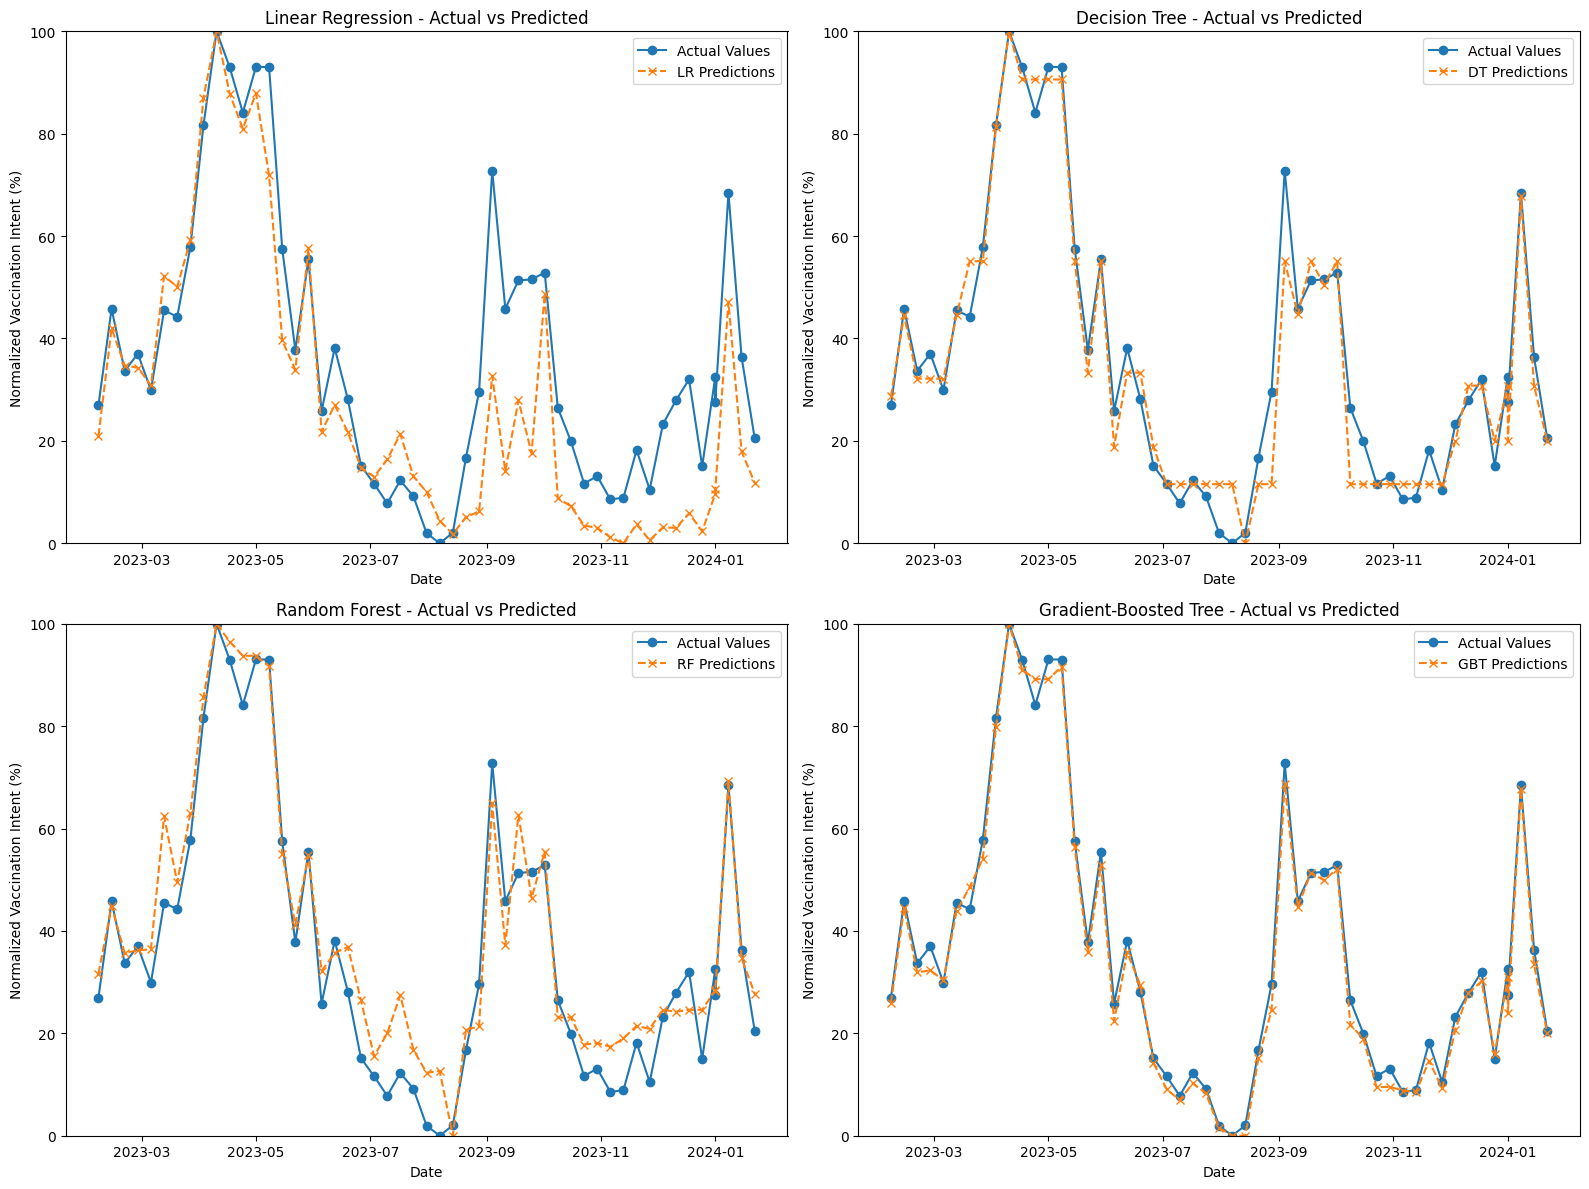

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

axs[0, 0].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[0, 0].plot(actual_dates, lr_predicted_values_normalized, label="LR Predictions", linestyle='--', marker='x')
axs[0, 0].legend()
axs[0, 0].set_title("Linear Regression - Actual vs Predicted")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Normalized Vaccination Intent (%)")
axs[0, 0].set_ylim(0, 100)

axs[0, 1].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[0, 1].plot(actual_dates, dt_predicted_values_normalized, label="DT Predictions", linestyle='--', marker='x')
axs[0, 1].legend()
axs[0, 1].set_title("Decision Tree - Actual vs Predicted")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Normalized Vaccination Intent (%)")
axs[0, 1].set_ylim(0, 100)

axs[1, 0].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[1, 0].plot(actual_dates, rf_predicted_values_normalized, label="RF Predictions", linestyle='--', marker='x')
axs[1, 0].legend()
axs[1, 0].set_title("Random Forest - Actual vs Predicted")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Normalized Vaccination Intent (%)")
axs[1, 0].set_ylim(0, 100)

axs[1, 1].plot(actual_dates, actual_values_normalized, label="Actual Values", marker='o')
axs[1, 1].plot(actual_dates, gbt_predicted_values_normalized, label="GBT Predictions", linestyle='--', marker='x')
axs[1, 1].legend()
axs[1, 1].set_title("Gradient-Boosted Tree - Actual vs Predicted")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Normalized Vaccination Intent (%)")
axs[1, 1].set_ylim(0, 100)

plt.tight_layout()
plt.show()
